##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/saeta/Just", from: "0.7.2")' Just

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/saeta/Just", from: "0.7.2")
		Just
With SwiftPM flags: []
Working in: /tmp/tmpo_xpfutr/swift-install
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/saeta/Just
Completed resolution in 3.24s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.3
Cloning https://github.com/saeta/Just
Resolving https://github.com/saeta/Just at 0.7.3
[1/11] Compiling Path Extensions.swift
[2/11] Compiling Path Path+Attributes.swift
[3/11] Compiling Path Path+Codable.swift
[4/11] Compiling Path Path+CommonDirectories.swift
[5/11] Compiling Path Path+FileManager.swift
[6/11] Compiling Path Path+StringConvertibles.swift
[7/11] Compiling Path Path+ls.swift
[8/11] Compiling Path Path->Bool.swift
[9/11] Compiling Path Path.swift
[10/12] Merging module Path
[12/13] Merging module Just
[13/14] Compiling jupyterInstalle

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

## **Generative Adversarial Network**

This tutorial demonstrates how to generate images of handwritten digits using a [Generative Adversarial Network](https://arxiv.org/pdf/1406.2661.pdf) (GAN). The code is written using the Swift for TensorFlow framework with a training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://tensorflow.org/beta/tutorials/generative/images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://tensorflow.org/beta/tutorials/generative/images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 10 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Import TensorFlow and other libraries

In [0]:
import TensorFlow
import Foundation
import Just
import Path
import Python

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

// Import Python modules.
let matplotlib = Python.import("matplotlib")
let plt = Python.import("matplotlib.pyplot")
let subprocess = Python.import("subprocess")
let os = Python.import("os")
let np = Python.import("numpy")
let glob = Python.import("glob")
let pil = Python.import("PIL")

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task,pipe) = (Process(),Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments,task.standardOutput) = (args,pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [5]:
public func downloadFile(url: String, destination: String? = nil, force: Bool = false) {
    let destinationName = destination ?? (Path.cwd/url.split(separator: "/").last!).string
    let urlDestination = URL(fileURLWithPath: (destination ?? (Path.cwd/url.split(separator: "/").last!).string))
    if !force && Path(destinationName)!.exists { return }

    print("Downloading \(url)...")

    if let content = Just.get(url).content {
        do    { try content.write(to: URL(fileURLWithPath:destinationName)) }
        catch { print("Can't write to \(urlDestination).\n\(error)") }
    } else {
        print("Can't reach \(url)")
    }
}

let files = ["t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte", "train-images-idx3-ubyte", "train-labels-idx1-ubyte"]

for file in files {
    downloadFile(url: "http://yann.lecun.com/exdb/mnist/\(file).gz")
    "/bin/gunzip".shell("-fq", "\(file).gz")
}

In [0]:
extension Tensor {
    public func minibatch(at index: Int, batchSize: Int) -> Tensor {
        let start = index * batchSize
        return self[start..<start+batchSize]
    }
}

In [0]:
/// Reads a file into an array of bytes.
func readFile(_ path: String, possibleDirectories: [String]) -> [UInt8] {
    for folder in possibleDirectories {
        let parent = URL(fileURLWithPath: folder)
        let filePath = parent.appendingPathComponent(path)
        guard FileManager.default.fileExists(atPath: filePath.path) else {
            continue
        }
        let data = try! Data(contentsOf: filePath, options: [])
        return [UInt8](data)
    }
    print("File not found: \(path)")
    exit(-1)
}

/// Reads MNIST images and labels from specified file paths.
func readMNIST(imagesFile: String, labelsFile: String, flattening: Bool, normalizing: Bool) -> (
    images: Tensor<Float>,
    labels: Tensor<Int32>
) {
    print("Reading data from files: \(imagesFile), \(labelsFile).")
    let images = readFile(imagesFile, possibleDirectories: [".", "./Datasets/MNIST"]).dropFirst(16)
        .map(Float.init)
    let labels = readFile(labelsFile, possibleDirectories: [".", "./Datasets/MNIST"]).dropFirst(8)
        .map(Int32.init)
    let rowCount = labels.count
    let imageHeight = 28
    let imageWidth = 28

    print("Constructing data tensors.")

    if flattening {
        var flattenedImages = Tensor(shape: [rowCount, imageHeight * imageWidth], scalars: images)
            / 255.0
        if normalizing {
            flattenedImages = flattenedImages * 2.0 - 1.0
        }
        return (images: flattenedImages, labels: Tensor(labels))
    } else {
        return (
            images: Tensor(shape: [rowCount, 1, imageHeight, imageWidth], scalars: images)
                .transposed(withPermutations: [0, 2, 3, 1]) / 255,  // NHWC
            labels: Tensor(labels)
        )
    }
}

In [0]:
public struct MNIST {
    public let trainingImages: Tensor<Float>
    public let trainingLabels: Tensor<Int32>
    public let testImages: Tensor<Float>
    public let testLabels: Tensor<Int32>

    public let trainingSize: Int
    public let testSize: Int

    public let batchSize: Int

    public init(batchSize: Int, flattening: Bool = false, normalizing: Bool = false) {
        self.batchSize = batchSize

        let (trainingImages, trainingLabels) = readMNIST(
            imagesFile: "train-images-idx3-ubyte",
            labelsFile: "train-labels-idx1-ubyte",
            flattening: flattening,
            normalizing: normalizing)
        self.trainingImages = trainingImages
        self.trainingLabels = trainingLabels
        self.trainingSize = Int(trainingLabels.shape[0])

        let (testImages, testLabels) = readMNIST(
            imagesFile: "t10k-images-idx3-ubyte",
            labelsFile: "t10k-labels-idx1-ubyte",
            flattening: flattening,
            normalizing: normalizing)
        self.testImages = testImages
        self.testLabels = testLabels
        self.testSize = Int(testLabels.shape[0])
    }
}

Define image and Training Loop parameters.

In [0]:
let epochCount = 10
let batchSize = 32
let outputFolder = "./output/"
let imageHeight = 28, imageWidth = 28
let imageSize = imageHeight * imageWidth
let latentSize = 64

Define image plot function to save and plot generated images.

In [0]:
/// Returns `size` samples of noise vector.
func sampleVector(size: Int) -> Tensor<Float> {
    Tensor(randomNormal: [size, latentSize])
}

// Noise vectors and plot function for testing
let testImageGridSize = 4
let testVector = sampleVector(size: testImageGridSize * testImageGridSize)

func plotImage(_ image: Tensor<Float>, name: String) {
    // Create figure.
    let ax = plt.gca()
    let array = np.array([image.scalars])
    let pixels = array.reshape(image.shape)
    if !FileManager.default.fileExists(atPath: outputFolder) {
        try! FileManager.default.createDirectory(
            atPath: outputFolder,
            withIntermediateDirectories: false,
            attributes: nil)
    }
    ax.imshow(pixels, cmap: "gray")
    plt.savefig("\(outputFolder)\(name).png", dpi: 300)
    plt.xlabel(name)
    plt.show()
    plt.close()
}


func plotTestImage(_ testImage: Tensor<Float>, name: String) {
    var gridImage = testImage.reshaped(to: [testImageGridSize, testImageGridSize,
                                            imageHeight, imageWidth])
    // Add padding.
    gridImage = gridImage.padded(forSizes: [(0, 0), (0, 0), (1, 1), (1, 1)], with: 1)
    // Transpose to create single image.
    gridImage = gridImage.transposed(withPermutations: [0, 2, 1, 3])
    gridImage = gridImage.reshaped(to: [(imageHeight + 2) * testImageGridSize,
                                        (imageWidth + 2) * testImageGridSize])
    // Convert [-1, 1] range to [0, 1] range.
    gridImage = (gridImage + 1) / 2
    plotImage(gridImage, name: name)
}

## Create the models

Both the generator and discriminator are defined using the Swift for TensorFlow framework.

### The Generator



The generator uses `Dense` and `BatchNorm` layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size. Notice the `LeakyReLU` activation for each layer, except the output layer which uses `tanh`.


### The Discriminator

The discriminator uses a series of fully-connected `Dense` layers to form an image classifier.

In [0]:
struct Generator: Layer {
    var dense1 = Dense<Float>(inputSize: latentSize, outputSize: latentSize * 2,
                              activation: { leakyRelu($0) })
    var dense2 = Dense<Float>(inputSize: latentSize * 2, outputSize: latentSize * 4,
                              activation: { leakyRelu($0) })
    var dense3 = Dense<Float>(inputSize: latentSize * 4, outputSize: latentSize * 8,
                              activation: { leakyRelu($0) })
    var dense4 = Dense<Float>(inputSize: latentSize * 8, outputSize: imageSize,
                              activation: tanh)
    
    var batchnorm1 = BatchNorm<Float>(featureCount: latentSize * 2)
    var batchnorm2 = BatchNorm<Float>(featureCount: latentSize * 4)
    var batchnorm3 = BatchNorm<Float>(featureCount: latentSize * 8)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        let x1 = batchnorm1(dense1(input))
        let x2 = batchnorm2(dense2(x1))
        let x3 = batchnorm3(dense3(x2))
        return dense4(x3)
    }
}

struct Discriminator: Layer {
    var dense1 = Dense<Float>(inputSize: imageSize, outputSize: 256,
                              activation: { leakyRelu($0) })
    var dense2 = Dense<Float>(inputSize: 256, outputSize: 64,
                              activation: { leakyRelu($0) })
    var dense3 = Dense<Float>(inputSize: 64, outputSize: 16,
                              activation: { leakyRelu($0) })
    var dense4 = Dense<Float>(inputSize: 16, outputSize: 1,
                              activation: identity)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        input.sequenced(through: dense1, dense2, dense3, dense4)
    }
}

## Define the dataset, loss and optimizers


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
@differentiable
func generatorLoss(fakeLogits: Tensor<Float>) -> Tensor<Float> {
    sigmoidCrossEntropy(logits: fakeLogits,
                        labels: Tensor(ones: fakeLogits.shape))
}

In [0]:
@differentiable
func discriminatorLoss(realLogits: Tensor<Float>, fakeLogits: Tensor<Float>) -> Tensor<Float> {
    let realLoss = sigmoidCrossEntropy(logits: realLogits,
                                       labels: Tensor(ones: realLogits.shape))
    let fakeLoss = sigmoidCrossEntropy(logits: fakeLogits,
                                       labels: Tensor(zeros: fakeLogits.shape))
    return realLoss + fakeLoss
}

In [14]:
let dataset = MNIST(batchSize: batchSize, flattening: true, normalizing: true)

var generator = Generator()
var discriminator = Discriminator()

let optG = Adam(for: generator, learningRate: 2e-4, beta1: 0.5)
let optD = Adam(for: discriminator, learningRate: 2e-4, beta1: 0.5)

Reading data from files: train-images-idx3-ubyte, train-labels-idx1-ubyte.
Constructing data tensors.
Reading data from files: t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte.
Constructing data tensors.


## Define the training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

## Train the model
Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 10 epochs, they resemble MNIST digits. This may take about some time with the default settings on Colab.

Start training...
[Epoch: 1] Loss-G: 1.1397076
[Epoch: 2] Loss-G: 1.1565795
[Epoch: 3] Loss-G: 1.1346556
[Epoch: 4] Loss-G: 1.141423
[Epoch: 5] Loss-G: 1.159514
[Epoch: 6] Loss-G: 1.1631528
[Epoch: 7] Loss-G: 1.1683161
[Epoch: 8] Loss-G: 1.1612381
[Epoch: 9] Loss-G: 1.167033
[Epoch: 10] Loss-G: 1.1639402


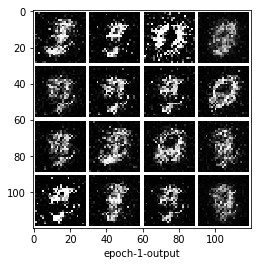

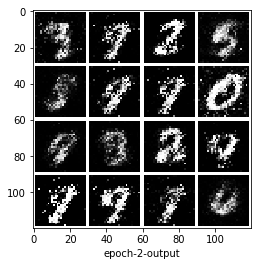

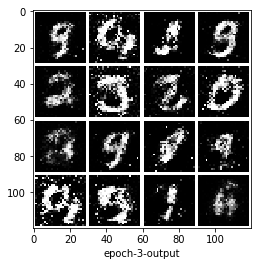

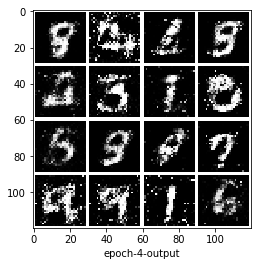

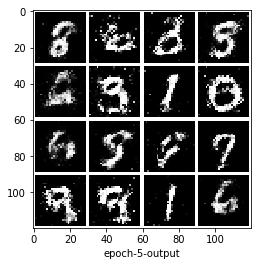

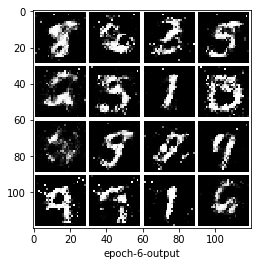

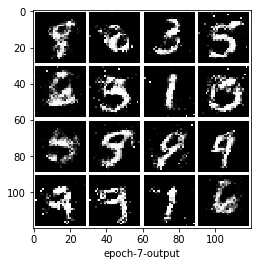

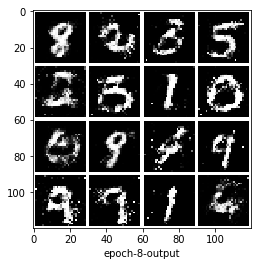

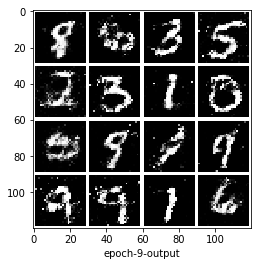

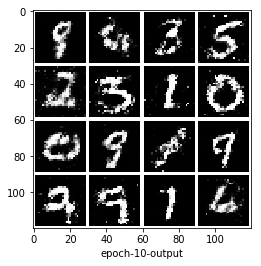

In [15]:
print("Start training...")

// Start training loop.
for epoch in 1...epochCount {
    // Start training phase.
    Context.local.learningPhase = .training
    for i in 0 ..< dataset.trainingSize / batchSize {
        // Perform alternative update.
        // Update generator.
        let vec1 = sampleVector(size: batchSize)
        
        let 𝛁generator = generator.gradient { generator -> Tensor<Float> in
            let fakeImages = generator(vec1)
            let fakeLogits = discriminator(fakeImages)
            let loss = generatorLoss(fakeLogits: fakeLogits)
            return loss
        }
        optG.update(&generator.allDifferentiableVariables, along: 𝛁generator)
        
        // Update discriminator.
        let realImages = dataset.trainingImages.minibatch(at: i, batchSize: batchSize)
        let vec2 = sampleVector(size: batchSize)
        let fakeImages = generator(vec2)
        
        let 𝛁discriminator = discriminator.gradient { discriminator -> Tensor<Float> in
            let realLogits = discriminator(realImages)
            let fakeLogits = discriminator(fakeImages)
            let loss = discriminatorLoss(realLogits: realLogits, fakeLogits: fakeLogits)
            return loss
        }
        optD.update(&discriminator.allDifferentiableVariables, along: 𝛁discriminator)
    }
    
    // Start inference phase.
    Context.local.learningPhase = .inference
    let testImage = generator(testVector)
    plotTestImage(testImage, name: "epoch-\(epoch)-output")
    
    let lossG = generatorLoss(fakeLogits: testImage)
    print("[Epoch: \(epoch)] Loss-G: \(lossG)")
}

This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset/home). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).

